In [101]:
# Insira sua resposta aqui
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
#!pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
sns.set()
from fbprophet import Prophet
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn import linear_model
import sklearn.metrics as metrics
from scipy.stats import zscore
from sklearn.svm import SVR, LinearSVR,NuSVR
from sklearn.naive_bayes import GaussianNB
sns.set()

In [4]:
comp_price = pd.read_csv('test_prc/comp_prices.csv', sep=',')
sales = pd.read_csv('test_prc/sales.csv', sep=',')

# B2W Challange

The sales.csv file contains transactional information where each line represents a sale. The comp_prices.csv file contains monitoring data of competitors’ prices. We have data available for 6 competitors, C1 to C6, which are monitored twice per day. The information below describes the data in each column:

- **PROD_ID**: Product ID. We provide data for 9 different products, P1 to P9;
- **DATE_ORDER**: Sales Date, under YYYY-MM-DD format;
- **QTY_ORDER*: Quantity Sold;
- **REVENUE**: Sale revenue. There can be variations of the price for the same product, depending on the sales channel or discounts, which are applied to the base price;
- **DATE_EXTRACTION**: Date and Time of the extraction of the competitors’ price, under YYYY-MM-DD HH:MM:SS format;
- **COMPETITOR**: Competitors’ ID (C1 to C6);
- **COMPETITOR_PRICE**: Competitors’ price per product, which can depend on the payment method;
- **PAY_TYPE**: Payment Method (1=deferred payment, 2=immediate payment).

1) Models for Demand Forecasting: The main objective is to create a model to predict the quantity sold for each product given a prescribed price. Along with the statistical model, we need metrics, relationships and descriptions of these data in order to understand the sales behavior. What does the data tell us? How are the different data sources related? Is there a particular competitor that seems more important?

2) Presentation of the results: we want to know what were the steps and your strategy (approach to the problem) during the analysis, even if these may seem wrong. The process you went through and the reasoning behind it, is as important as the solutions you found. For this, please prepare a clear and objective presentation to explain both your methodology and your results. In case you are selected for the interview, you will need to make a 20-minute (max) presentation.

In [5]:
sales['DATE_ORDER'] = pd.to_datetime(sales['DATE_ORDER'])
comp_price['DATE_EXTRACTION_DAY'] = pd.to_datetime(comp_price['DATE_EXTRACTION'].str.split(' ').str[0]) #compare extration by day
comp_price['DATE_EXTRACTION'] = pd.to_datetime(comp_price['DATE_EXTRACTION'])

# Data Preparing

Dado o objetivo do problema prescrito (quantidade vendida de cada produto dado um preço) entende-se que a métrica COMPETITOR_PRICE é de grande relevância para a previsão e a mesma será utilizada como feature do modelo. Para isso será necessária a criação da relação dos dados por dia e produto.

In [6]:
sales_agg = sales.groupby(['PROD_ID','DATE_ORDER']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['min']}).reset_index()
sales_agg.columns = sales_agg.columns.get_level_values(0)
sales_agg

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P1,2015-02-04,10.0,1499.00
1,P1,2015-02-05,12.0,1349.10
2,P1,2015-02-06,21.0,1349.10
3,P1,2015-02-07,4.0,1499.00
4,P1,2015-02-08,7.0,1499.00
...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89
2158,P9,2015-10-11,87.0,388.66
2159,P9,2015-10-12,110.0,388.63
2160,P9,2015-10-13,328.0,341.10


In [7]:
comp_dummies = pd.get_dummies(data=comp_price, columns=['COMPETITOR', 'PAY_TYPE'])

columns = ['PROD_ID',
            'DATE_EXTRACTION_DAY', 
            'COMPETITOR_C1', 
            'COMPETITOR_C2', 
            'COMPETITOR_C3', 
            'COMPETITOR_C4', 
            'COMPETITOR_C5', 
            'COMPETITOR_C6', 
            'PAY_TYPE_1', 
            'PAY_TYPE_2']

comp_price_agg = comp_dummies.groupby(columns).agg({'COMPETITOR_PRICE': ['min']}).reset_index()
comp_price_agg.columns = comp_price_agg.columns.get_level_values(0)
comp_price_agg

,PROD_ID,DATE_EXTRACTION_DAY,COMPETITOR_C1,COMPETITOR_C2,COMPETITOR_C3,COMPETITOR_C4,COMPETITOR_C5,COMPETITOR_C6,PAY_TYPE_1,PAY_TYPE_2,COMPETITOR_PRICE
0,P1,2015-03-15,0,0,0,0,0,1,0,1,1499.00
1,P1,2015-03-15,0,0,0,0,0,1,1,0,1499.00
2,P1,2015-03-15,0,0,0,0,1,0,0,1,1499.00
3,P1,2015-03-15,0,0,0,0,1,0,1,0,1499.00
4,P1,2015-03-16,0,0,0,0,0,1,0,1,1499.00
...,...,...,...,...,...,...,...,...,...,...,...
17315,P9,2015-10-14,0,0,1,0,0,0,1,0,393.00
17316,P9,2015-10-14,0,1,0,0,0,0,0,1,393.96
17317,P9,2015-10-14,0,1,0,0,0,0,1,0,393.96
17318,P9,2015-10-14,1,0,0,0,0,0,0,1,393.00


In [8]:
comp_price_agg_min_f = comp_price_agg.groupby(['PROD_ID','DATE_EXTRACTION_DAY']).agg({'COMPETITOR_PRICE': 'last'}).reset_index()
comp_price_agg_min_f

,PROD_ID,DATE_EXTRACTION_DAY,COMPETITOR_PRICE
0,P1,2015-03-15,1499.00
1,P1,2015-03-16,1362.50
2,P1,2015-03-17,1362.50
3,P1,2015-03-18,1362.50
4,P1,2015-03-19,1499.00
...,...,...,...
1927,P9,2015-10-10,395.82
1928,P9,2015-10-11,395.82
1929,P9,2015-10-12,395.76
1930,P9,2015-10-13,393.00


In [9]:
df = pd.DataFrame.merge(sales_agg, comp_price_agg_min_f, how='left', left_on=['PROD_ID','DATE_ORDER'], right_on = ['PROD_ID','DATE_EXTRACTION_DAY']).drop(['DATE_EXTRACTION_DAY'], axis=1)
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE
0,P1,2015-02-04,10.0,1499.00,NaN
1,P1,2015-02-05,12.0,1349.10,NaN
2,P1,2015-02-06,21.0,1349.10,NaN
3,P1,2015-02-07,4.0,1499.00,NaN
4,P1,2015-02-08,7.0,1499.00,NaN
...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82
2158,P9,2015-10-11,87.0,388.66,395.82
2159,P9,2015-10-12,110.0,388.63,395.76
2160,P9,2015-10-13,328.0,341.10,393.00


# Remoção de outliers

O tratamento dos outliers foram executados por itens e tratados nos valores com base no desvio padrão acima de 3. Para o COMPETITOR_PRICE os outliers foram substituidos pelo mesmo valor de REVENUE correspondente, os demais receberam a média por produto. 

In [10]:
base = 'PROD_ID'

for b in df[base].unique():
    n = df["REVENUE"].loc[df[base] == b]
    n,m = n[np.abs(zscore(n)) > 3].index, 'REVENUE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].loc[df[base] == b].mean()

    n = df["QTY_ORDER"].loc[df[base] == b]
    n,m = n[np.abs(zscore(n)) > 3].index, 'QTY_ORDER'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['QTY_ORDER'].loc[df[base] == b].mean()
    
    n,m = df['COMPETITOR_PRICE'].loc[(np.isnan(df['COMPETITOR_PRICE'])) & (df[base] == b)].index, 'COMPETITOR_PRICE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].iloc[int(i)]

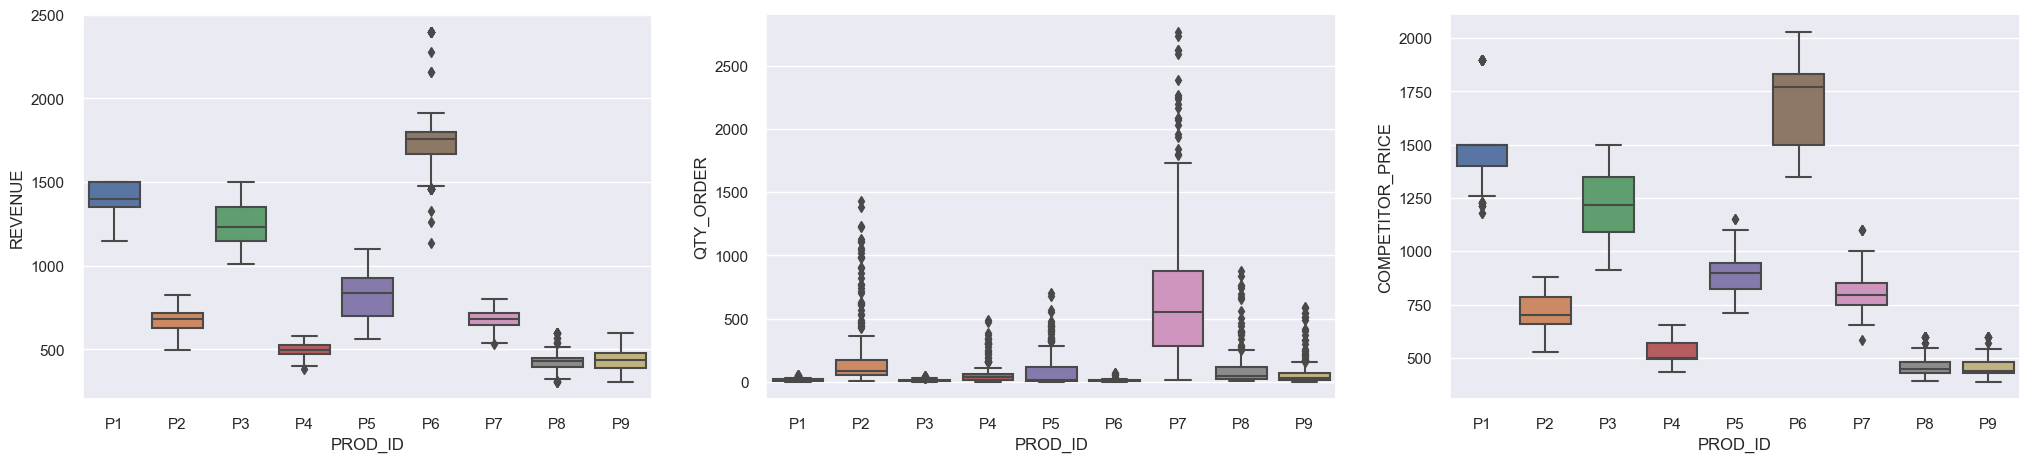

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df, x='PROD_ID', y='REVENUE', ax=ax[0])
sns.boxplot(data=df, x='PROD_ID', y='QTY_ORDER', ax=ax[1])
sns.boxplot(data=df, x='PROD_ID', y='COMPETITOR_PRICE', ax=ax[2])
plt.show()

# Transform to supervised

Decidi optar pela utilização de modelos supervisionados para a solução do problema afim de obter mais possibilidades de parametrização e diversidade de modelos. Para isso efetuei a transformação do meu problema para um ambiente supervisionado. 

Podemos usar a função shift () no Pandas para criar automaticamente novos enquadramentos de problemas de série temporal, dado o comprimento desejado das sequências de entrada e saída.

Essa seria uma ferramenta útil, pois nos permitiria explorar diferentes enquadramentos de um problema de série temporal com algoritmos de aprendizado de máquina para ver o que poderia resultar em modelos de melhor desempenho.

In [12]:
def transform_to_supervised(df,
                            previous_steps=1, 
                            forecast_steps=1,
                            dropnan=True):

    """
    Transforms a DataFrame containing time series data into a DataFrame
    containing data suitable for use as a supervised learning problem.
    
    Derived from code originally found at 
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    :param df: pandas DataFrame object containing columns of time series values
    :param previous_steps: the number of previous steps that will be included in the
                           output DataFrame corresponding to each input column
    :param forecast_steps: the number of forecast steps that will be included in the
                           output DataFrame corresponding to each input column
    :return Pandas DataFrame containing original columns, renamed <orig_name>(t), as well as
            columns for previous steps, <orig_name>(t-1) ... <orig_name>(t-n) and columns 
            for forecast steps, <orig_name>(t+1) ... <orig_name>(t+n)
    """
    
    # original column names
    col_names = df.columns
    print(col_names)
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [13]:
base = 'PROD_ID'
columns = ['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE']

df_transformed = pd.DataFrame()


for b in df[base].unique():

    dft = transform_to_supervised(df[columns].loc[df[base] == b], previous_steps=2, forecast_steps=3)
    dft[base] = b
    df_transformed = df_transformed.append(dft, ignore_index=True,sort=False)

df_transformed

Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')


,QTY_ORDER(t-2),REVENUE(t-2),COMPETITOR_PRICE(t-2),QTY_ORDER(t-1),REVENUE(t-1),COMPETITOR_PRICE(t-1),QTY_ORDER(t),REVENUE(t),COMPETITOR_PRICE(t),QTY_ORDER(t+1),REVENUE(t+1),COMPETITOR_PRICE(t+1),QTY_ORDER(t+2),REVENUE(t+2),COMPETITOR_PRICE(t+2),PROD_ID
0,10.0,1499.00,1499.00,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,P1
1,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,P1
2,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,P1
3,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,P1
4,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,16.0,1259.10,1259.10,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,50.0,359.10,414.00,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,P9
2122,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,P9
2123,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,P9
2124,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,328.0,341.10,393.00,P9


# Análise exploratória

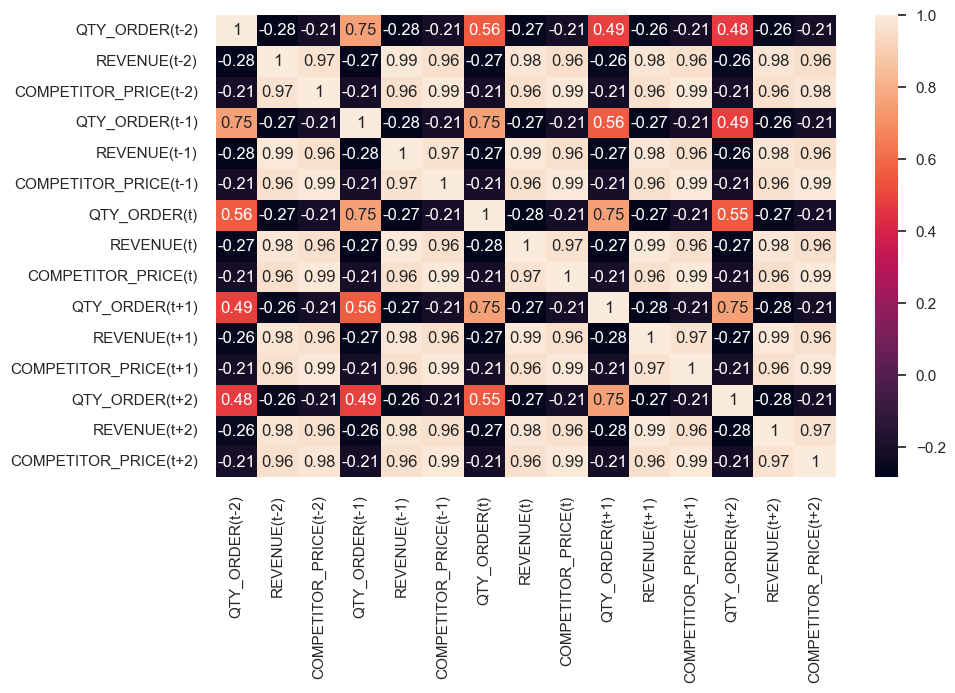

In [14]:
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_transformed.corr(), ax=ax, annot=True)
plt.show()

# Criação de Features

In [15]:
X = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"])
y = df_transformed["QTY_ORDER(t)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Predição do Modelo

## Regressão Linear

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.7373905184894303
0.7283440751903624


### Validação dos resultados

R2 Score Train:  0.7377421529065161
R2 Score Test:  0.7208316848007603


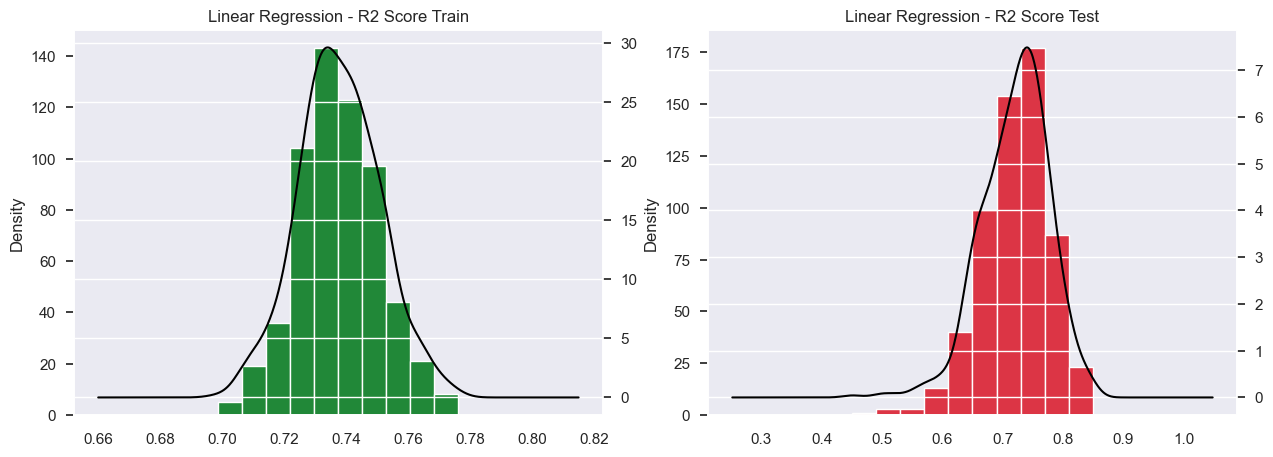

In [17]:
model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred)}
    predict_traning.append(mdl)

model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("Linear Regression - R2 Score Train")
model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("Linear Regression - R2 Score Test")
model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')

print("R2 Score Train: ", model_report['r2_score_train'].mean())
print("R2 Score Test: ", model_report['r2_score_test'].mean())
plt.show()

# SVC

# Polynomial Regression

In [18]:
poly = PolynomialFeatures(degree=2)
poly_variables = poly.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(poly_variables, y, test_size = 0.2)

regression = linear_model.LinearRegression()
model = regression.fit(X_train, y_train)

# score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.8197142613169803
0.6374528004501658


### Validação dos resultados

R2 Score Train:  0.8106026041578306
R2 Score Test:  0.694185543048998


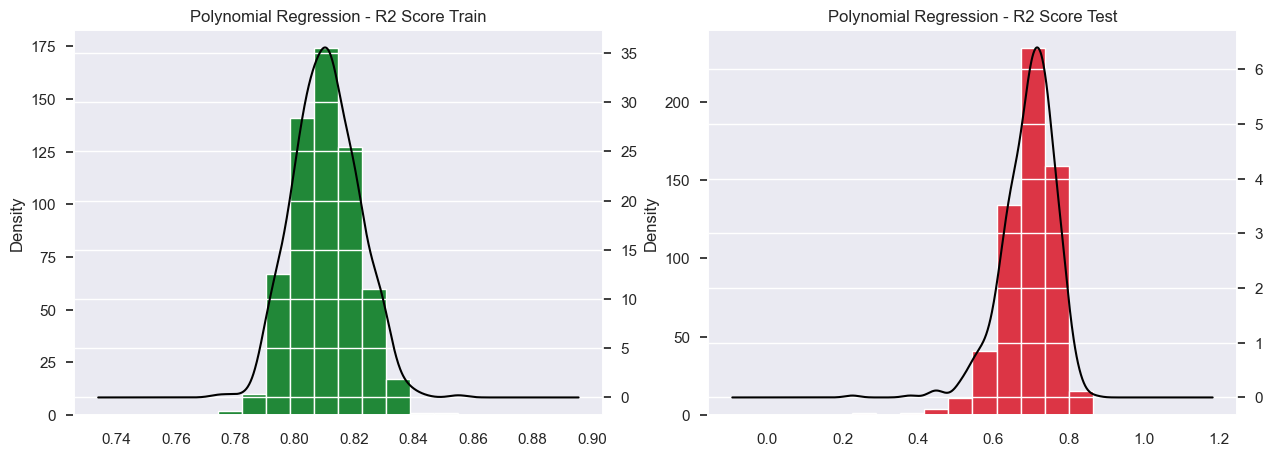

In [20]:
model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(poly_variables, y, test_size = 0.2)

    regression = linear_model.LinearRegression()
    model = regression.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred)}
    predict_traning.append(mdl)

model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("Polynomial Regression - R2 Score Train")
model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("Polynomial Regression - R2 Score Test")
model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')

print("R2 Score Train: ", model_report['r2_score_train'].mean())
print("R2 Score Test: ", model_report['r2_score_test'].mean())
plt.show()

# XGBoost

In [21]:
model = XGBRegressor(max_depth=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.8348066702252832
0.6899662378214797


### Validação dos resultados

R2 Score Train:  0.9945831959228683
R2 Score Test:  0.6639488480113294


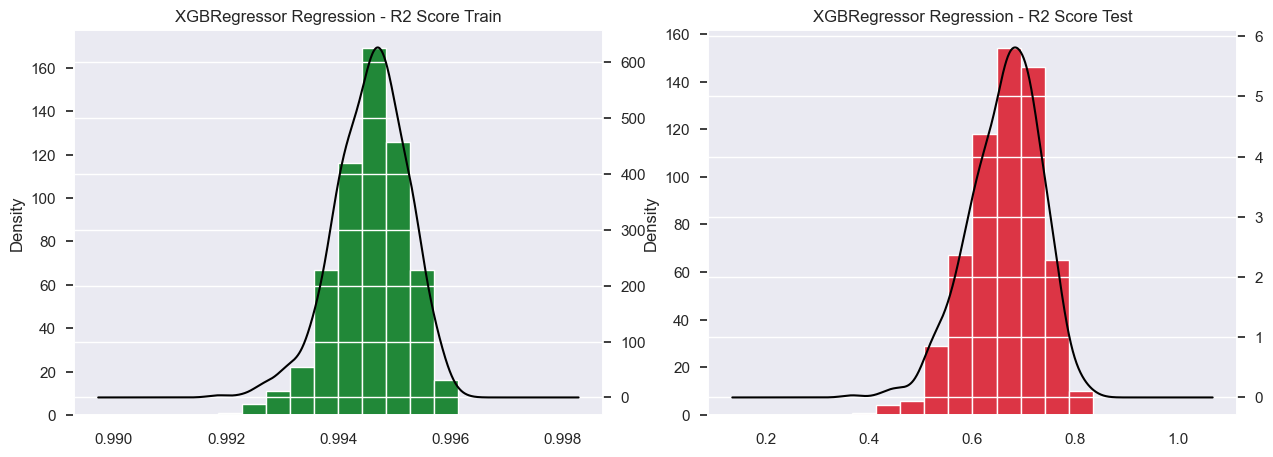

In [22]:
model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    model = XGBRegressor(max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred)}
    predict_traning.append(mdl)

model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axes[0].set_title("XGBRegressor Regression - R2 Score Train")
model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("XGBRegressor Regression - R2 Score Test")
model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')

print("R2 Score Train: ", model_report['r2_score_train'].mean())
print("R2 Score Test: ", model_report['r2_score_test'].mean())
plt.show()

# Testes Alternativos

## K-means

In [ ]:
# df2 = df.groupby(['PROD_ID']).agg({'QTY_ORDER': ['median'], 'REVENUE': ['median'], 'COMPETITOR_PRICE': ['median']}).reset_index()
df2 = df.groupby(['PROD_ID']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['sum']}).reset_index()
df2.columns = df2.columns.get_level_values(0)
df2_prodid = df2["PROD_ID"]
df2 = df2.drop(columns=["PROD_ID"])
df2
# 

,QTY_ORDER,REVENUE
0,3929.719740,350170.510000
1,48145.034629,192613.600000
2,2739.879920,312235.060000
3,13244.636182,99144.201190
4,17077.011080,149408.145137
5,2723.437701,490546.872857
6,143471.510941,193632.176743
7,21722.860091,90318.957238
8,15231.237397,91751.650000


In [ ]:
# df2 = df.drop(columns=["PROD_ID", "DATE_ORDER"])

scaler = MinMaxScaler()
scaler.fit(df2)
scaled_df = scaler.transform(df2)
scaled_df = pd.DataFrame(scaled_df, columns=df2.columns)
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   QTY_ORDER  9 non-null      float64
 1   REVENUE    9 non-null      float64
dtypes: float64(2)
memory usage: 272.0 bytes


In [ ]:
inertias = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    print(f"n_clusters= {i}, inertia={kmeans.inertia_}")
    

C:\Users\erycm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters= 1, inertia=1.7677722941862106
n_clusters= 2, inertia=0.8371003814000538
n_clusters= 3, inertia=0.20267153996786721
n_clusters= 4, inertia=0.09698550942897292
n_clusters= 5, inertia=0.021307992174263234
n_clusters= 6, inertia=0.006792854576009959
n_clusters= 7, inertia=0.0022650603020614034


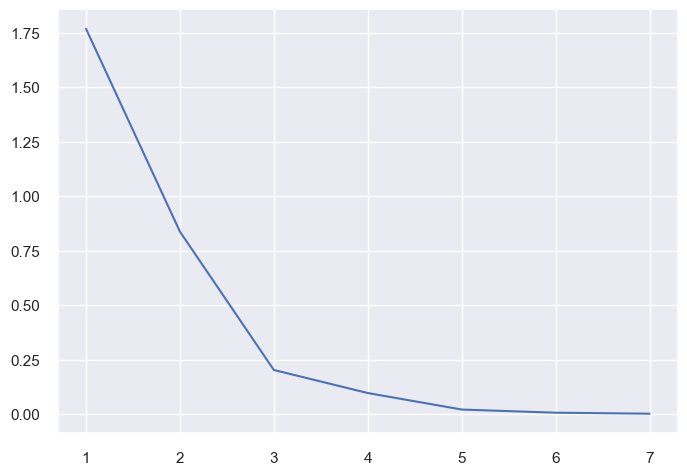

In [ ]:
sns.lineplot(y=inertias, x=range(1,8))
plt.show()

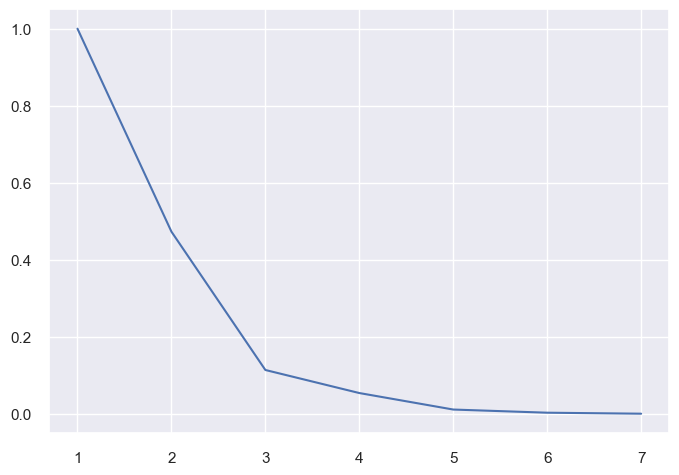

In [ ]:
inertias_pct = [w/inertias[0] for w in inertias]
sns.lineplot(y=inertias_pct, x=range(1,8))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)
cluster_label = kmeans.predict(scaled_df)
df2["LABEL"] = cluster_label

df2 = pd.concat([df2_prodid, df2], axis=1)
df2


,PROD_ID,QTY_ORDER,REVENUE,LABEL
0,P1,3929.719740,350170.510000,1
1,P2,48145.034629,192613.600000,0
2,P3,2739.879920,312235.060000,1
3,P4,13244.636182,99144.201190,0
4,P5,17077.011080,149408.145137,0
5,P6,2723.437701,490546.872857,1
6,P7,143471.510941,193632.176743,2
7,P8,21722.860091,90318.957238,0
8,P9,15231.237397,91751.650000,0


In [ ]:
label = [] 
for prod in df['PROD_ID'].values:
    label.append(int(df2['LABEL'].loc[df2['PROD_ID'] == prod].values[0]))

df['LABEL'] = label
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE,LABEL
0,P1,2015-02-04,10.0,1499.00,1499.00,1
1,P1,2015-02-05,12.0,1349.10,1349.10,1
2,P1,2015-02-06,21.0,1349.10,1349.10,1
3,P1,2015-02-07,4.0,1499.00,1499.00,1
4,P1,2015-02-08,7.0,1499.00,1499.00,1
...,...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82,0
2158,P9,2015-10-11,87.0,388.66,395.82,0
2159,P9,2015-10-12,110.0,388.63,395.76,0
2160,P9,2015-10-13,328.0,341.10,393.00,0


In [ ]:
df2.groupby(["LABEL"]).count()

,PROD_ID,QTY_ORDER,REVENUE
LABEL,,,
0,5,5,5
1,3,3,3
2,1,1,1


# Exploratory Analysis

## Outliers

In [ ]:
base = 'PROD_ID'

for b in df[base].unique():
    n,m = df["REVENUE"][np.abs(zscore(df["REVENUE"])) > 3].loc[df[base] == b].index, 'REVENUE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].loc[df[base] == b].mean()

    n,m = df["QTY_ORDER"][np.abs(zscore(df["QTY_ORDER"])) > 3].loc[df[base] == b].index, 'QTY_ORDER'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['QTY_ORDER'].loc[df[base] == b].mean()
    
    n,m = df['COMPETITOR_PRICE'].loc[(np.isnan(df['COMPETITOR_PRICE'])) & (df[base] == b)].index, 'COMPETITOR_PRICE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].iloc[int(i)]

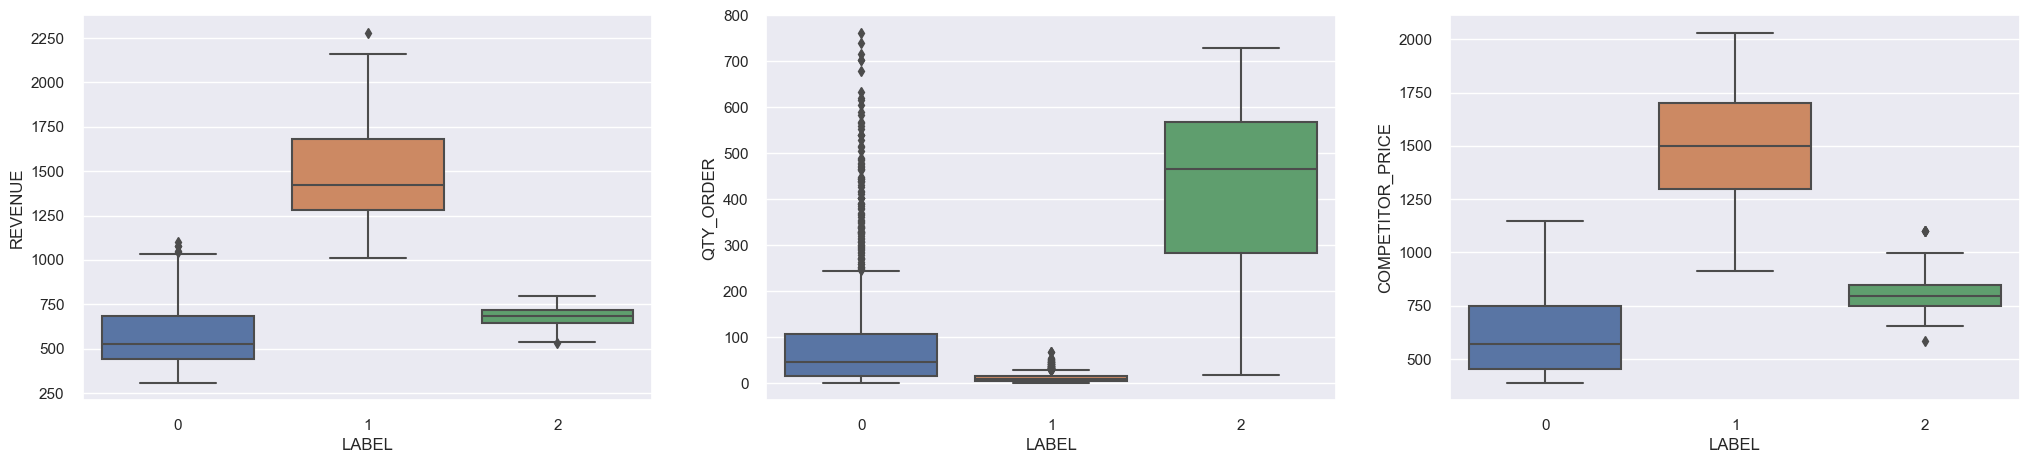

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df, x='LABEL', y='REVENUE', ax=ax[0])
sns.boxplot(data=df, x='LABEL', y='QTY_ORDER', ax=ax[1])
sns.boxplot(data=df, x='LABEL', y='COMPETITOR_PRICE', ax=ax[2])
plt.show()

In [ ]:
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE,LABEL
0,P1,2015-02-04,10.0,1499.00,1499.00,1
1,P1,2015-02-05,12.0,1349.10,1349.10,1
2,P1,2015-02-06,21.0,1349.10,1349.10,1
3,P1,2015-02-07,4.0,1499.00,1499.00,1
4,P1,2015-02-08,7.0,1499.00,1499.00,1
...,...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82,0
2158,P9,2015-10-11,87.0,388.66,395.82,0
2159,P9,2015-10-12,110.0,388.63,395.76,0
2160,P9,2015-10-13,328.0,341.10,393.00,0


# Criando features

In [ ]:
# df_0 = df.loc[df['LABEL'] == 0].reset_index()
# X0 = df_0.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER'])
# y0 = df_0["QTY_ORDER"]
# X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=.20)

# df_1 = df.loc[df['LABEL'] == 1].reset_index()
# X1 = df_1.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER'])
# y1 = df_1["QTY_ORDER"]
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=.20)

# df_2 = df.loc[df['LABEL'] == 2].reset_index()
# X2 = df_2.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER'])
# y2 = df_2["QTY_ORDER"]
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.20)

In [ ]:
def transform_to_supervised(df,
                            previous_steps=1, 
                            forecast_steps=1,
                            dropnan=True):

    """
    Transforms a DataFrame containing time series data into a DataFrame
    containing data suitable for use as a supervised learning problem.
    
    Derived from code originally found at 
    https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    
    :param df: pandas DataFrame object containing columns of time series values
    :param previous_steps: the number of previous steps that will be included in the
                           output DataFrame corresponding to each input column
    :param forecast_steps: the number of forecast steps that will be included in the
                           output DataFrame corresponding to each input column
    :return Pandas DataFrame containing original columns, renamed <orig_name>(t), as well as
            columns for previous steps, <orig_name>(t-1) ... <orig_name>(t-n) and columns 
            for forecast steps, <orig_name>(t+1) ... <orig_name>(t+n)
    """
    
    # original column names
    col_names = df.columns
    print(col_names)
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [ ]:
base = 'PROD_ID'
columns = ['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE']

df_transformed = pd.DataFrame()


for b in df[base].unique():

    dft = transform_to_supervised(df[columns].loc[df[base] == b], previous_steps=2, forecast_steps=3)
    dft[base] = b
    df_transformed = df_transformed.append(dft, ignore_index=True,sort=False)

df_transformed


Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')


,QTY_ORDER(t-2),REVENUE(t-2),COMPETITOR_PRICE(t-2),QTY_ORDER(t-1),REVENUE(t-1),COMPETITOR_PRICE(t-1),QTY_ORDER(t),REVENUE(t),COMPETITOR_PRICE(t),QTY_ORDER(t+1),REVENUE(t+1),COMPETITOR_PRICE(t+1),QTY_ORDER(t+2),REVENUE(t+2),COMPETITOR_PRICE(t+2),PROD_ID
0,10.0,1499.00,1499.00,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,P1
1,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,P1
2,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,P1
3,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,P1
4,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,16.0,1259.10,1259.10,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,50.0,359.10,414.00,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,P9
2122,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,P9
2123,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,P9
2124,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,328.0,341.10,393.00,P9


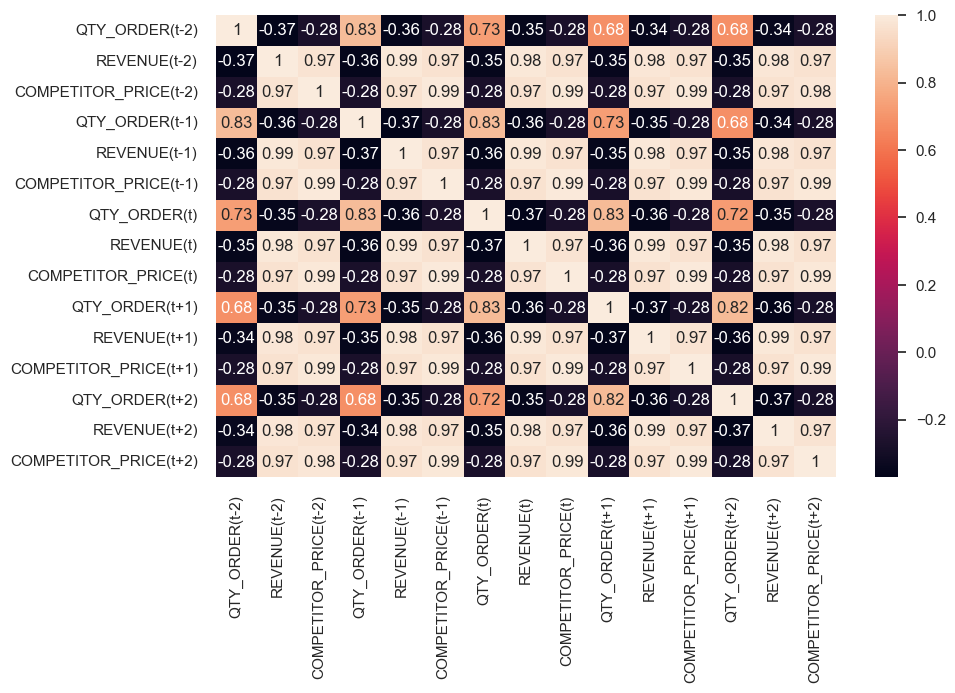

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_transformed.corr(), ax=ax, annot=True)
plt.show()

In [ ]:
scaler = MinMaxScaler()

X = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"])
y = df_transformed["QTY_ORDER(t)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

print("---------------------------------------------------------------")

model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.7985969871181169
0.8015830706070275
---------------------------------------------------------------
0.7985969871181169
0.8015830706070276


# Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.7985969871181169
0.8015830706070275


In [ ]:
for cluster in df['LABEL'].unique():
    X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[df['LABEL'] == cluster]
    y = df["QTY_ORDER"].loc[df['LABEL'] == cluster]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
    print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))

Cluster label train 1 :  0.17279480644342438
Cluster label pred 1 :  0.12871831495463582
Cluster label train 0 :  0.29159532018094336
Cluster label pred 0 :  0.24898735309036635
Cluster label train 2 :  0.23382730465146617
Cluster label pred 2 :  0.24263344480258509


# Polinomial Regression

In [ ]:
X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL'])
y = df["QTY_ORDER"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X_train) 
poly.fit(X_poly, y_train) 

PolynomialFeatures(degree=4)

In [ ]:
lm = linear_model.LinearRegression() 
lm.fit(X_poly, y_train) 
predictions = lm.predict(poly.fit_transform(X_test))
print('r2_score= ', metrics.r2_score(y_test, predictions))

r2_score=  0.5274563815719745


In [ ]:
# scaler = MinMaxScaler()

# X = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"])
# y = df_transformed["QTY_ORDER(t)"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# scaler.fit(X_train)
# X_train_transformed = scaler.transform(X_train)
# X_test_transformed = scaler.transform(X_test)

# poly = PolynomialFeatures(degree = 4) 
# X_poly = poly.fit_transform(X_train) 
# # model.fit(X_train, y_train)
# poly.fit(X_poly, y_train) 
# # y_pred = model.predict(X_test)

# # print(r2_score(y_train, y_pred_train))
# # print(r2_score(y_test, y_pred))
# lm = linear_model.LinearRegression() 
# lm.fit(X_poly, y_train) 
# predictions = lm.predict(poly.fit_transform(X_test))
# print('r2_score= ', metrics.r2_score(y_test, predictions))

# # print("---------------------------------------------------------------")

# # poly = PolynomialFeatures(degree = 4) 
# # X_poly = poly.fit_transform(X_train_transformed) 
# # # model.fit(X_train_transformed, y_train)
# # poly.fit(X_poly, y_train) 
# # # y_pred = model.predict(X_test_transformed)

# # # print(r2_score(y_train, y_pred_train))
# # # print(r2_score(y_test, y_pred))
# # lm = linear_model.LinearRegression() 
# # lm.fit(X_poly, y_train) 
# # y_pred_train = lm.predict(X_train)

# # print(r2_score(y_train, y_pred_train))
# # print(r2_score(y_test, y_pred))

# XGBoost

In [ ]:
scaler = MinMaxScaler()

X = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"])
y = df_transformed["QTY_ORDER(t)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

model = XGBRegressor(max_depth=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

print("---------------------------------------------------------------")

model = XGBRegressor(max_depth=1)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))

0.8307124131856235
0.8147168698229972
---------------------------------------------------------------
0.8307124131856235
0.8147168698229972


In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

cluster = 0
lbl = df['LABEL'] == cluster

X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[lbl]
y = df["QTY_ORDER"].loc[lbl]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model = XGBRegressor(max_depth=2)
model.fit(X_train.loc[lbl], y_train.loc[lbl])
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))
print("mean_absolute_percentage_error pred:", mean_absolute_percentage_error(y_test, y_pred))
print("mean_absolute_percentage_error train:", mean_absolute_percentage_error(y_train, y_pred_train))
print("-------------")

# #----------------------------------------------------------------------------------------------------------

cluster = 1
lbl = df['LABEL'] == cluster

X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[lbl]
y = df["QTY_ORDER"].loc[lbl]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model2 = XGBRegressor(max_depth=2)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_pred_train = model2.predict(X_train)
print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))
print("mean_absolute_percentage_error pred:", mean_absolute_percentage_error(y_test, y_pred))
print("mean_absolute_percentage_error train:", mean_absolute_percentage_error(y_train, y_pred_train))
print("-------------")

# #----------------------------------------------------------------------------------------------------------

cluster = 2
lbl = df['LABEL'] == cluster

X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL']).loc[lbl]
y = df["QTY_ORDER"].loc[lbl]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model3 = XGBRegressor(max_depth=2)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred_train = model3.predict(X_train)
print("Cluster label train",cluster, ": ",r2_score(y_train, y_pred_train))
print("Cluster label pred",cluster, ": ",r2_score(y_test, y_pred))
print("mean_absolute_percentage_error pred:", mean_absolute_percentage_error(y_test, y_pred))
print("mean_absolute_percentage_error train:", mean_absolute_percentage_error(y_train, y_pred_train))

Cluster label train 0 :  0.6976916900530025
Cluster label pred 0 :  0.5165930397058944
mean_absolute_percentage_error pred: 1.9675269963730928
mean_absolute_percentage_error train: 1.2073649402158042
-------------
Cluster label train 1 :  0.5758971882983344
Cluster label pred 1 :  0.2319586393824501
mean_absolute_percentage_error pred: 0.8191682372547311
mean_absolute_percentage_error train: 0.775650410200974
-------------
Cluster label train 2 :  0.7064097643643324
Cluster label pred 2 :  -0.12128273008319779
mean_absolute_percentage_error pred: 0.3956033668543845
mean_absolute_percentage_error train: 0.36789687798309406


# Sarimax

# Prophet 

In [ ]:
X = df.drop(columns=["QTY_ORDER", 'PROD_ID', 'DATE_ORDER', 'LABEL'])
y = df["QTY_ORDER"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
df[['DATE_ORDER', 'REVENUE']]

,DATE_ORDER,REVENUE
0,2015-02-04,1499.00
1,2015-02-05,1349.10
2,2015-02-06,1349.10
3,2015-02-07,1499.00
4,2015-02-08,1499.00
...,...,...
2157,2015-10-10,388.89
2158,2015-10-11,388.66
2159,2015-10-12,388.63
2160,2015-10-13,341.10
